In [48]:
from scipy.stats import norm
import numpy as np
import matplotlib.pylab as plt
import pandas as pd


def phi(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    return norm.cdf(d1)


def psi_Bt(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return -K*np.exp(-r*T)*norm.cdf(d2)


def simulate_Brownian_Motion(paths, steps, T):
    deltaT = T/steps
    t = np.linspace(0, T, steps+1)
    X = np.c_[np.zeros((paths, 1)),
              np.random.randn(paths, steps)]
    return t, np.cumsum(np.sqrt(deltaT) * X, axis=1)


In [39]:
def simulate_hedging_errors(steps, paths):
    maturity = 1.0 / 12

    r = 0.05
    S0 = 100.0
    K = 100.0
    sigma = 0.2
    dt = maturity / steps
    
    T, W_T_list = simulate_Brownian_Motion(paths, steps, maturity)
      
    errors = []

    for i in range(paths):
        W_T = W_T_list[i]
        blackscholespath = S0*np.exp((r-sigma**2/2)*T + sigma*W_T)

        # Get error for simulation path
        deltas = []
        stockhedge_errors = []
        bondhedge_errors = []
        hedged_portfolios = []
        stock_holdings = []
        bond_holdings = []
        for t, S_t in zip(T, blackscholespath):
            stock_pos = phi(S_t, K, r, sigma, maturity-t)*S_t
            bond_pos = psi_Bt(S_t, K, r, sigma, maturity-t)
            V_t = stock_pos + bond_pos
            stock_holdings.append(stock_pos)
            bond_holdings.append(bond_pos)
            hedged_portfolios.append(V_t)
            deltas.append(phi(S_t, K, r, sigma, maturity-t))
            if t == 0.0:
                stockhedge_errors.append(0)
                bondhedge_errors.append(0)
            else:
                # This is the PNL between prev timestep and current timestep
                # We should expect these 2 errors to sum to 0 if perfectly hedged
                stockhedge_errors.append(prev_phi*S_t - stock_pos)
                bondhedge_errors.append(prev_bond_pos*np.exp(r*dt) - bond_pos)

            prev_phi = phi(S_t, K, r, sigma, maturity-t)
            prev_bond_pos = bond_pos

        error_for_path = sum(stockhedge_errors) + sum(bondhedge_errors)
        errors.append(error_for_path)
        
        # Print every 500 iterations so we know it's still progressing
        if (i % 500 == 0):
            print(i, sum(stockhedge_errors), sum(bondhedge_errors), error_for_path)
    
    return errors


In [40]:
num_paths = 50000

errors_21_steps = simulate_hedging_errors(21, num_paths)
errors_84_steps = simulate_hedging_errors(84, num_paths)

<ipython-input-23-13baf892d6b7>:7: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
<ipython-input-23-13baf892d6b7>:12: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))


0 51.525636993087225 -51.63201678983873 -0.10637979675150433
500 51.8187131998058 -51.754840675109435 0.06387252469636451
1000 51.184324113945834 -51.61763428497683 -0.4333101710309961
1500 51.42475119573658 -51.75236091185204 -0.32760971611545386
2000 51.72886554285278 -51.657920111018726 0.07094543183405477
2500 51.23125417401517 -51.58568251812757 -0.35442834411239943
3000 51.443282164119 -51.67626520032068 -0.2329830362016807
3500 -47.59662615581399 48.224036219541276 0.6274100637272824
4000 -48.3244947334615 48.149886255751206 -0.17460847771029364
4500 -49.35892506448738 48.106371847251985 -1.2525532172353948
5000 51.22673168519092 -51.57661573003974 -0.34988404484882096
5500 52.32339192168838 -51.70160124980869 0.621790671879694
6000 -48.38882779810278 48.12953262454558 -0.25929517355719867
6500 -50.103288912129315 48.32318784487698 -1.7801010672523319
7000 -47.947206246194156 48.15261248471918 0.20540623852502193
7500 -48.24360881954094 48.31285290237473 0.0692440828337908
8000 

15000 -47.944632591722296 48.20704255940693 0.26240996768463276
15500 51.691874772181656 -51.69812812991609 -0.006253357734436804
16000 -47.91772832173816 48.23597855559045 0.31825023385228945
16500 -48.15170072368169 48.10116812920523 -0.050532594476464965
17000 -48.06865744867032 48.32031071360039 0.25165326493007
17500 -48.04982464098461 48.150966965379375 0.10114232439476467
18000 51.42999551110925 -51.626864430923845 -0.1968689198145981
18500 -48.19366920931335 48.131300048847216 -0.06236916046613317
19000 -47.983228333082735 48.13962495661394 0.15639662353120798
19500 51.64455734027736 -51.611868262838236 0.03268907743912308
20000 -48.360443958898735 48.26041768488457 -0.1000262740141622
20500 -48.728324495727215 48.347104693835576 -0.38121980189163907
21000 -47.84645629997154 48.178964927951036 0.3325086279794931
21500 51.71259257395842 -51.668313020839264 0.04427955311915355
22000 51.58071281492485 -51.71539335312454 -0.13468053819968873
22500 -48.37158105259368 48.271949237171

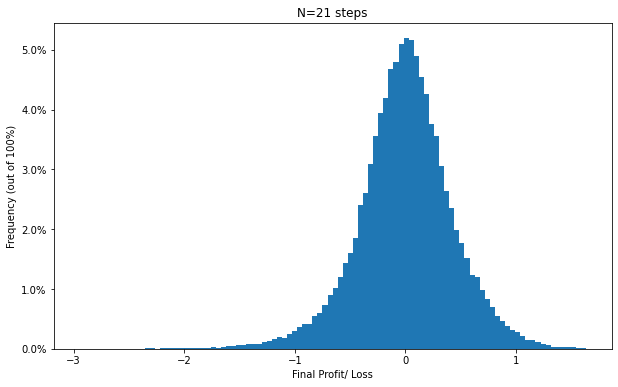

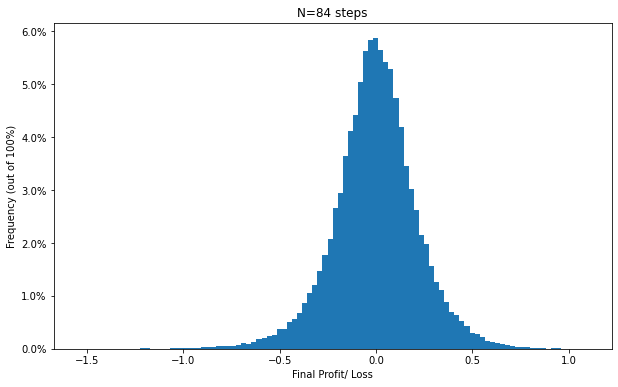

In [47]:
from matplotlib.ticker import PercentFormatter

steps = [21, 84]

for i, errors in enumerate([errors_21_steps, errors_84_steps]):
    plt.figure(figsize=(10, 6))
    plt.hist(errors, weights=np.ones(len(errors)) / len(errors), bins=100)

    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.title('N={} steps'.format(steps[i]))
    plt.xlabel('Final Profit/ Loss')
    plt.ylabel('Frequency (out of 100%)')
    plt.show()

In [51]:
pd.DataFrame({'N = 21': errors_21_steps}).describe()

,N = 21
count,50000.000000
mean,-0.000850
std,0.427783
min,-2.953048
25%,-0.242647
50%,0.006318
75%,0.255298
max,1.635206


In [52]:
pd.DataFrame({'N = 84': errors_84_steps}).describe()

,N = 84
count,50000.000000
mean,-0.002646
std,0.217044
min,-1.541343
25%,-0.126111
50%,-0.001063
75%,0.123304
max,1.091325


In [53]:
def BlackScholesLognormalCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

In [56]:
call_value = BlackScholesLognormalCall(100, 100, 0.05, 0.2, 1/12)
call_value

2.5120670860398846

In [60]:
0.427783 / call_value

0.1702912324186266

In [61]:
0.217044 / call_value

0.0864005588091822